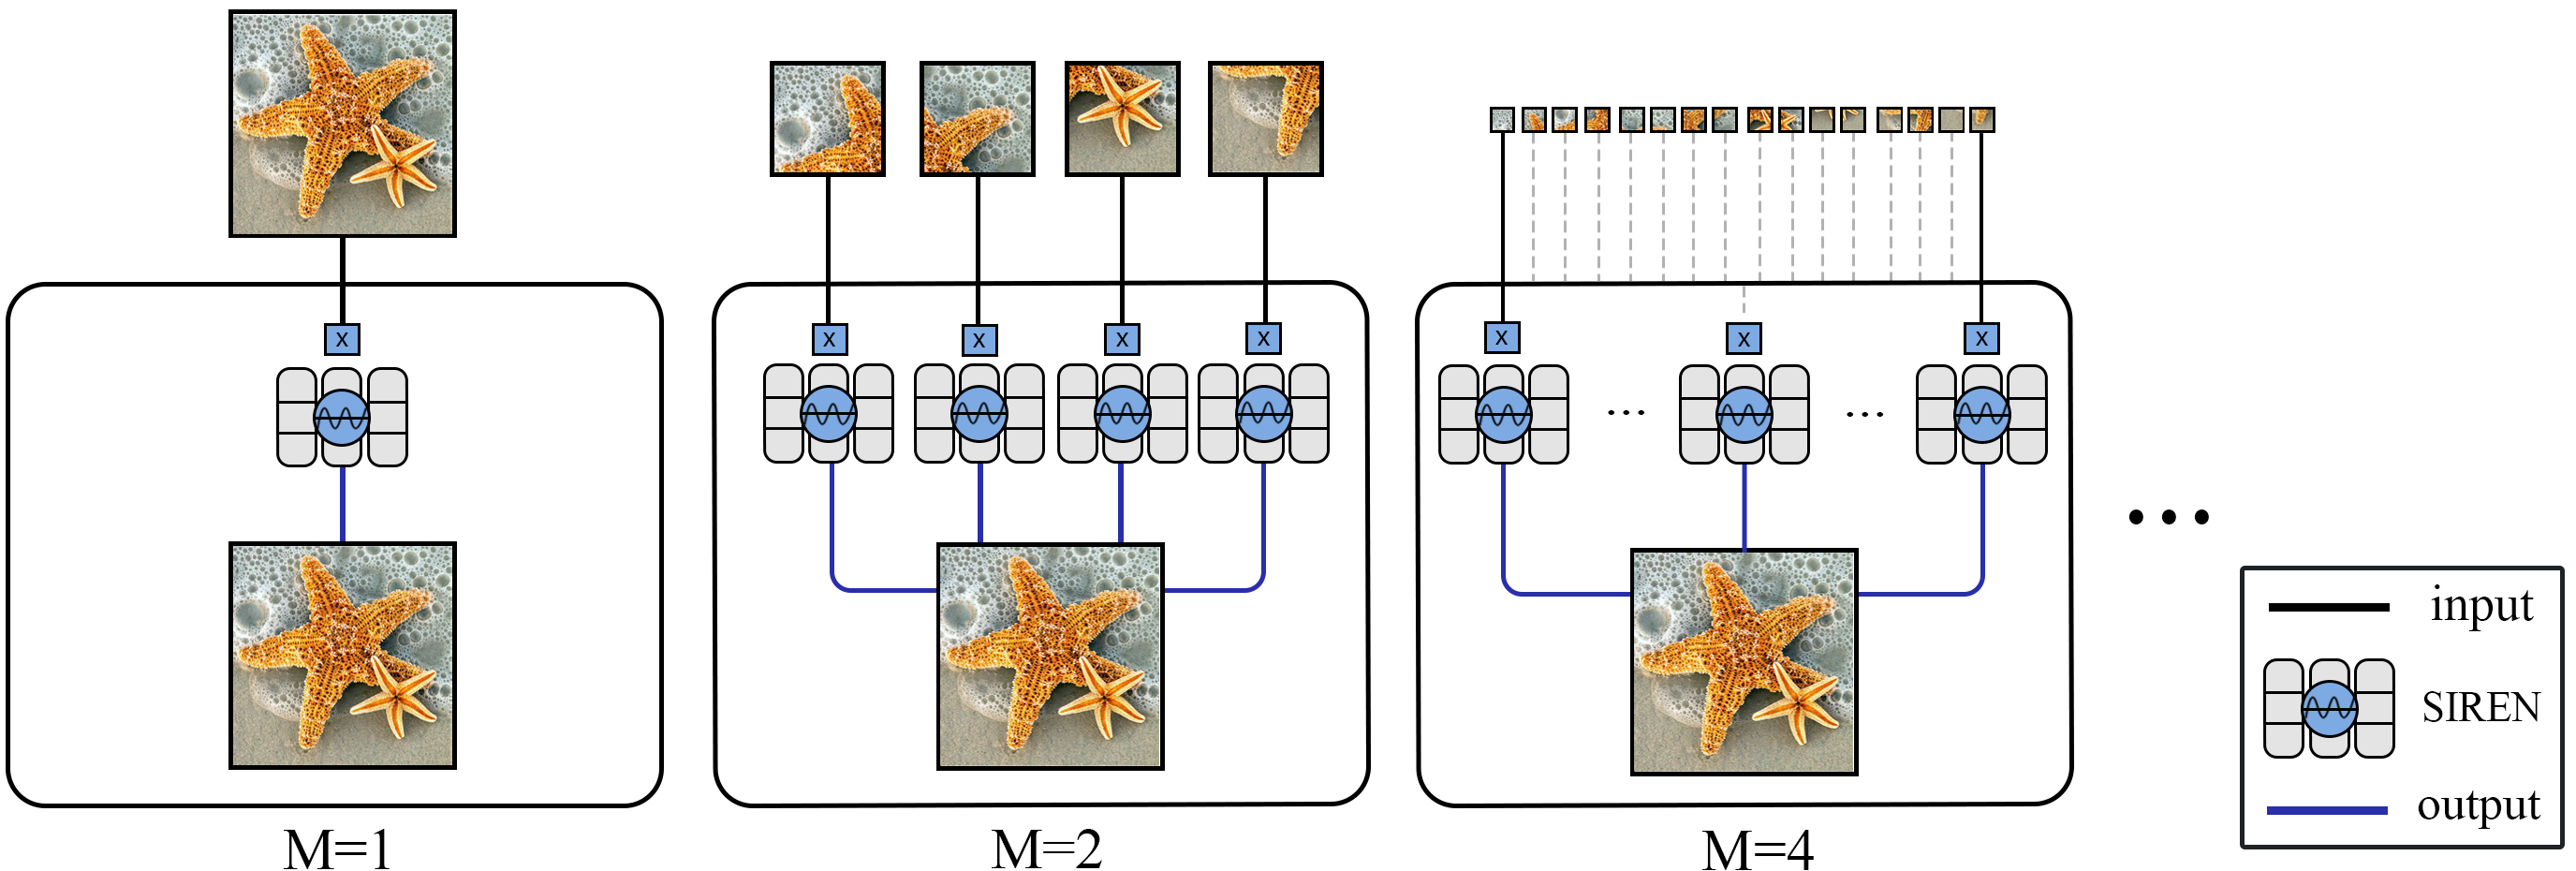

In [1]:
!git clone https://github.com/AlirezaMorsali/ENRP.git

Cloning into 'ENRP'...
remote: Enumerating objects: 266, done.
remote: Counting objects: 100% (266/266), done.
remote: Compressing objects: 100% (232/232), done.
remote: Total 266 (delta 102), reused 151 (delta 27), pack-reused 0
Receiving objects: 100% (266/266), 11.40 MiB | 23.44 MiB/s, done.
Resolving deltas: 100% (102/102), done.


In [37]:
%cd /content/ENRP
!pip install -r requirements.txt

/content/ENRP


In [116]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
import imageio
import pandas as pd
import seaborn as sns
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
from utils import *

In [119]:
# [Grid_size, depth, width]

ENRP_models = {
    'ENRP-S0': [2,5,64],
    'ENRP-S1': [4,2,64],
    'ENRP-S2': [8,1,128],
    'ENRP-S3': [16,1,128],
    'ENRP-S4': [32,1,128],
    'SIREN':   [1,3,256],
}

In [120]:
image= cv2.imread('./train_images/Image.jpg')
n_steps = 501
batch_size = 8

outputs = {}
for model in ENRP_models.keys():
  print(model)
  grid, depth, width = ENRP_models[model]

  result = train_GPSiren(image=image, image_sidelength=[128, 128], hidden_features = width,
                        hidden_layers=depth, grid_ratio=grid, total_steps=n_steps, summary_plot=False,
                        store_images=True, save_frame_rate=1,
                        n_batches= batch_size , parallel_model = grid>2, save_model=False) 
  outputs[model] = result

ENRP-S0


  0%|          | 0/501 [00:00<?, ?it/s]

ENRP-S1


  0%|          | 0/501 [00:00<?, ?it/s]

ENRP-S2


  0%|          | 0/501 [00:00<?, ?it/s]

ENRP-S3


  0%|          | 0/501 [00:00<?, ?it/s]

ENRP-S4


  0%|          | 0/501 [00:00<?, ?it/s]

SIREN


  0%|          | 0/501 [00:00<?, ?it/s]

# Plot Results

## Video

In [121]:
path = 'output'
output_file = os.makedirs(path, exist_ok=True)

all_preds = np.concatenate([outputs[n]['images'] for n in outputs], axis=-2)
data8 = (255*np.clip(all_preds,0,1)).astype(np.uint8)

f = os.path.join(path, 'training_convergence.mp4')
imageio.mimwrite(f, data8, fps=20)

# Display Video
from IPython.display import HTML
from base64 import b64encode
mp4 = open(f, 'rb').read()

data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML(f'''
<video width=1024 controls autoplay loop>
  <source src="{data_url}" type="video/mp4">
</video>
<table width="1024" cellspacing="0" cellpadding="0">
  <tr>{''.join(len(outputs)*[f'<td width="{1000//len(outputs)}"></td>'])}</tr>
  <tr>{''.join(len(outputs)*['<td style="text-align:center">{}</td>'])}</tr>
</table>
'''.format(*list(outputs.keys())))

## Image 

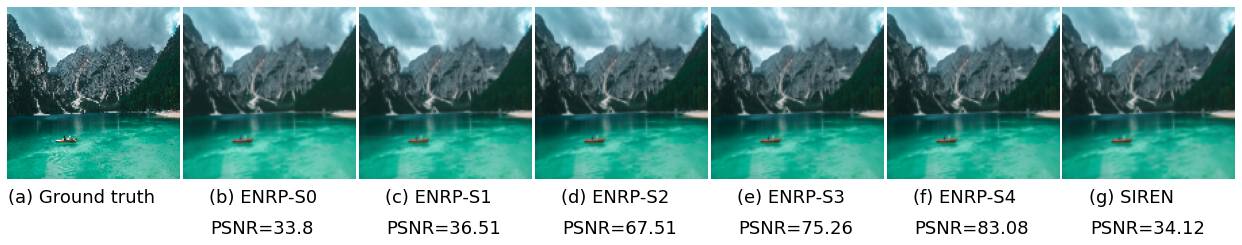

In [122]:
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman']
plt.rcParams['mathtext.default'] = 'regular'

fig, ax = plt.subplots(1, 7, figsize = (22,6), gridspec_kw = {'wspace':0.02, 'hspace':0})

psnr = [''] + [round(20*np.log10(1.0/np.sqrt(outputs[i]['losses'][-1])), 2) for i in outputs]
alph = ['a', 'b', 'c', 'd', 'e', 'f','g', 'h']
N = ['Ground truth','ENRP-S0','ENRP-S1','ENRP-S2','ENRP-S3','ENRP-S4','SIREN']

gt = cv2.resize(image, outputs['SIREN']['images'][-1].shape[:2])
images = [gt[...,::-1]] + [outputs[i]['images'][-1] for i in outputs]

for c, img in enumerate(images):
    ax[c].imshow(img)
    ax[c].axis('off')
    
    if c == 0:
        ax[c].text(0, 145, f'({alph[c]}) {N[c]}', size=18)
    else:
        ax[c].text(19, 145, f'({alph[c]}) {N[c]}', size=18)
        ax[c].text(20, 168, f'PSNR={psnr[c]}', size=18)
        
        
    ax[c].set_xticklabels([])
    ax[c].set_yticklabels([])
    

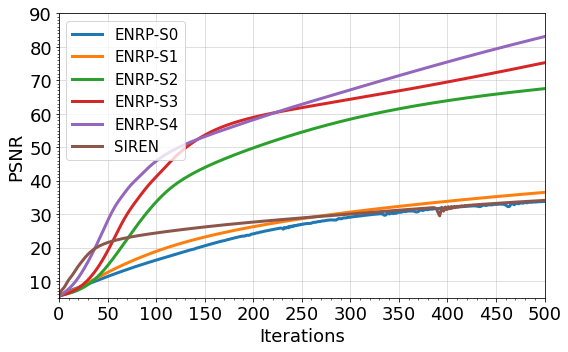

In [125]:
axis_size = 18
labelsize = 18
legsize = 15

bars = ['ENRP-S0','ENRP-S1','ENRP-S2','ENRP-S3','ENRP-S4','SIREN',]

fig, ax = plt.subplots(1, 1, figsize = (8,5))

for c, model in enumerate(outputs):
    y = pd.DataFrame({'PSNR': 20*np.log10(1.0/np.sqrt(outputs[model]['losses']))})
    try:
        bar = bars[c]
    except: pass
    
    our_plot = sns.lineplot(data=y[:501], x=y.index[:501], y="PSNR", label = bar, ax = ax,linewidth=3)

# Plot settings
our_plot.legend(prop={'size': legsize})
our_plot.grid(which = 'major', alpha = 0.5)

our_plot.xaxis.set_major_locator(MultipleLocator(50))
our_plot.yaxis.set_major_locator(MultipleLocator(10))    

our_plot.xaxis.set_minor_locator(MultipleLocator(10))
our_plot.yaxis.set_minor_locator(MultipleLocator(1))

our_plot.set_xlabel('Iterations', size = axis_size)
our_plot.set_ylabel('PSNR', size = axis_size)

plt.axis([0, 500, 5, 90])

plt.rc('xtick', labelsize=labelsize) 
plt.rc('ytick', labelsize=labelsize) 
plt.tight_layout()